# Exploring Addbot's "doom month"

Load the English Wikipedia table of bot-bot reverts, process dates:

In [1]:
library(data.table)
library(ggplot2)

dt = data.table(read.table("../../datasets/reverted_bot2bot/enwiki_20170420.tsv.bz2", sep="\t", header=T, quote="",
                          comment.char=""))
dt$rev_ts = as.POSIXct(format(dt$rev_timestamp, scientific=F), format="%Y%m%d%H%M%S")
dt$rev_month = as.Date(paste(format(dt$rev_ts, "%Y-%m-"), "01", sep=""))
dt$rev_day = as.Date(dt$rev_ts)
dt$reverting_ts = as.POSIXct(format(dt$reverting_timestamp, scientific=F), format="%Y%m%d%H%M%S")
dt$reverting_month = as.Date(paste(format(dt$reverting_ts, "%Y-%m-"), "01", sep=""))
dt$reverting_day = as.Date(dt$reverting_ts)

What does this dataframe look like?

In [2]:
head(dt)


rev_id,rev_timestamp,rev_user,rev_user_text,rev_page,rev_sha1,rev_minor_edit,rev_deleted,rev_parent_id,archived,⋯,rev_revert_offset,revisions_reverted,reverted_to_rev_id,page_namespace,rev_ts,rev_month,rev_day,reverting_ts,reverting_month,reverting_day
273691771,2.009023e+13,6505923,Kbdankbot,5040439,qj45ne2z4yfexmpaz5wfnbm2yrmqt4j,False,False,259117355,False,⋯,1,1,259117355,0,2009-02-27 17:35:07,2009-02-01,2009-02-28,2009-02-28 02:19:25,2009-02-01,2009-02-28
136526894,2.007061e+13,4534303,PbBot,3046554,3xtnw7u4w9h6cg1smw97mqnr1en6a55,False,False,120932016,False,⋯,1,1,120932016,1,2007-06-07 04:42:09,2007-06-01,2007-06-07,2009-02-10 23:03:37,2009-02-01,2009-02-11
506140139,2.012081e+13,5570079,PixelBot,13693134,kfi23g79zarzum6nfu4bp7sc0zpig9j,True,False,282784287,False,⋯,1,1,282784287,0,2012-08-06 23:02:28,2012-08-01,2012-08-07,2013-03-17 16:50:42,2013-03-01,2013-03-17
480021175,2.012030e+13,6929011,CarsracBot,9518147,hwnqcwihv5ca5ijyzw4mk6q4o67ouep,True,False,472951378,False,⋯,1,1,472951378,0,2012-03-03 19:13:45,2012-03-01,2012-03-04,2012-06-05 18:20:02,2012-06-01,2012-06-06
147117624,2.007073e+13,279219,RussBot,11539331,6szcxb7xgiz6vub80iznv0oggnciyc3,True,False,135093925,False,⋯,1,1,135093925,0,2007-07-26 00:29:18,2007-07-01,2007-07-26,2012-11-17 01:09:56,2012-11-01,2012-11-17
349876265,2.010031e+13,11292982,EmausBot,18754878,1sp9240gjlgx8llm5z0dpd57v0pd4hg,False,False,293896099,False,⋯,11,11,293896099,14,2010-03-14 21:10:51,2010-03-01,2010-03-15,2013-03-19 08:55:44,2013-03-01,2013-03-19


How many bot-bot reverts per month?

In [3]:
month_reverts = dt[page_namespace == 0,list(reverts=length(rev_id)), list(reverting_month)]
month_reverts[order(month_reverts$reverts, decreasing=T)][1:10,]

reverting_month,reverts
2013-03-01,79586
2011-08-01,6018
2013-04-01,4021
2013-02-01,3997
2013-01-01,3193
2011-11-01,2921
2012-09-01,2660
2012-02-01,2629
2011-09-01,2495
2011-07-01,2491


In the "doom month" of March 2013, which bots made the most bot-bot reverts?

In [4]:
doom_reverts = dt[
    page_namespace == 0 & reverting_month == "2013-03-01", 
    list(reverts=length(rev_id)), 
    list(reverting_user_text)]
doom_reverts[order(doom_reverts$reverts, decreasing=T)][1:10,]

reverting_user_text,reverts
Addbot,73275
EmausBot,3230
KLBot2,1083
AvicBot,886
AvocatoBot,459
Legobot,272
DumbBOT,150
Xqbot,94
タチコマ robot,65
JAnDbot,53


In this month, who is Addbot reverting?

In [5]:
addbot_reverts = dt[
    page_namespace == 0 & reverting_month == "2013-03-01" & reverting_user_text == "Addbot", 
    list(reverteds=length(rev_id)), 
    list(rev_user_text)]
addbot_reverts[order(addbot_reverts$reverteds, decreasing=T)][1:10,]

rev_user_text,reverteds
EmausBot,15182
ZéroBot,12837
TuHan-Bot,4483
Luckas-bot,3837
Makecat-bot,3384
Zorrobot,3071
Thijs!bot,2805
SieBot,2034
MystBot,1751
YFdyh-bot,1702


## Visualization

### Plot the frequency of reverts:

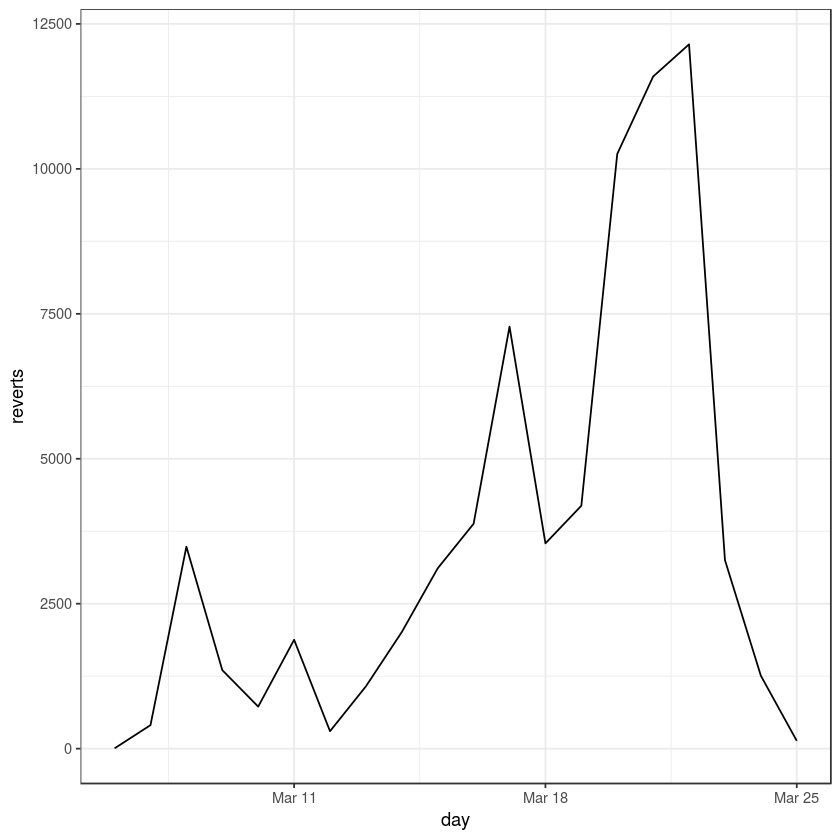

In [6]:
addbot_doom_month = dt[
    page_namespace == 0 & reverting_user_text == "Addbot" & reverting_ts >= "2013-03-05" & reverting_ts < "2013-03-25", 
    list(reverts=length(rev_id)), 
    list(day=as.Date(reverting_ts))]
ggplot(addbot_doom_month, aes(x=day, y=reverts)) + 
theme_bw() + 
geom_line()

### Time to revert -- how long ago were these original edits made before Addbot reverted them?

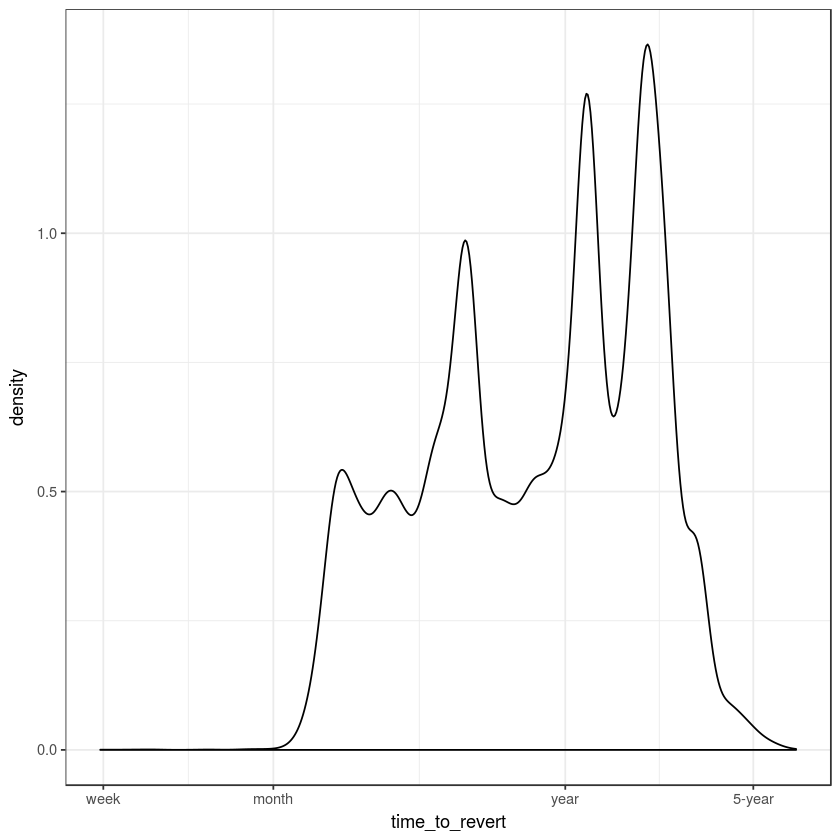

In [7]:
addbot_time_to_revert = dt[
    page_namespace == 0 & reverting_user_text == "Addbot" & reverting_ts >= "2013-03-05" & reverting_ts < "2013-03-25", 
    list(time_to_revert=as.numeric(difftime(reverting_ts, rev_ts, units="secs")))]
ggplot(addbot_time_to_revert, aes(x=time_to_revert)) + 
theme_bw() + 
geom_density() + 
scale_x_log10(breaks=c(60*60*24, 60*60*24*7, 60*60*24*30, 60*60*24*365, 60*60*24*365*5), 
              labels=c("day",    "week",     "month",     "year",       "5-year"))